In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import cv2
from keras.utils import to_categorical

from keras import layers
from keras import optimizers
from keras.models import Sequential
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
path_dir ='/kaggle/input/utkface-new/UTKFace'

In [5]:
data_to_list = os.listdir(path_dir) #Go path and list files
print("Number Of İmages: ", len(data_to_list))

Number Of İmages:  23708


In [6]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(path_dir)):
    image_path = os.path.join(path_dir, filename)
    temp = filename.split('_')
  
    age = int(temp[0])          # First part: age
    gender = int(temp[1])       # Second part: gender
    
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)


print("Number of images processed:", len(image_paths))
print("Sample Age Labels:", age_labels[:10])
print("Sample Gender Labels:", gender_labels[:10])


  0%|          | 0/23708 [00:00<?, ?it/s]

Number of images processed: 23708
Sample Age Labels: [26, 22, 21, 28, 17, 44, 35, 76, 36, 34]
Sample Gender Labels: [0, 1, 1, 0, 1, 0, 0, 0, 1, 0]


In [7]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [8]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [9]:
# Gender classification
gender_classes = []
y_gender = []
for i in gender_labels:  # Use gender_labels here, not gender as it was undefined
    i = int(i)
    if i == 0:
        gender_classes.append(0)
    else:
        gender_classes.append(1)
    y_gender.append(i)

gender_classes = np.array(gender_classes)
print("gender_classes shape: ", gender_classes.shape)

gender_classes shape:  (23708,)


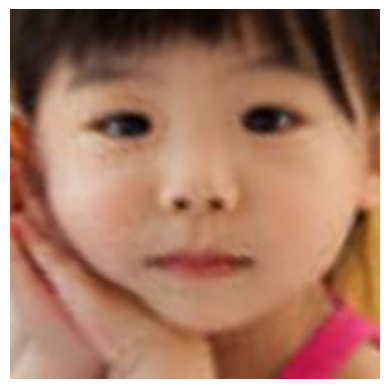

In [10]:
# Read the image using OpenCV
img = cv2.imread(df['image'][100])

# Convert the image from BGR (OpenCV default) to RGB (matplotlib expects RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.axis('off')  # Turn off the axis
plt.imshow(img_rgb)  # Display the image
plt.show()


<Axes: xlabel='age', ylabel='Density'>

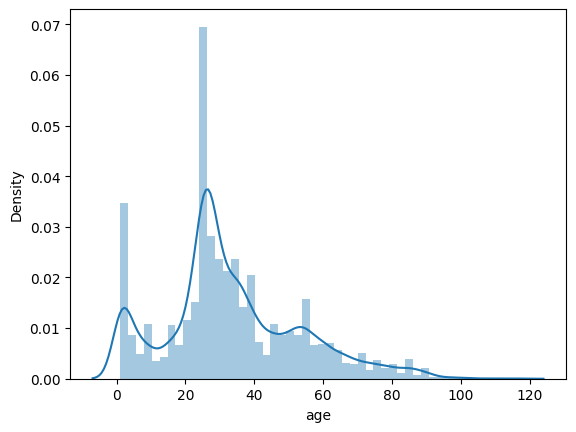

In [11]:
sns.distplot(df['age'])

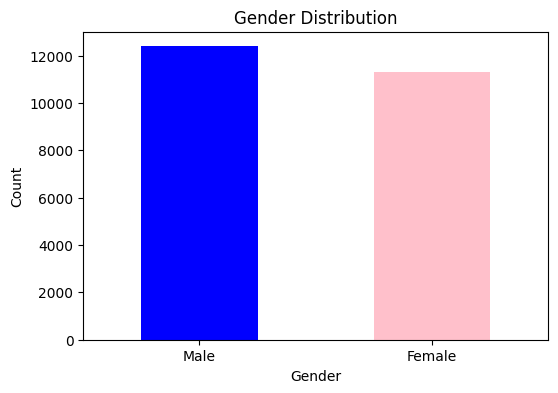

In [12]:
# Use value_counts to count occurrences
gender_counts = df["gender"].value_counts()

# Plot
gender_counts.plot(kind="bar", color=["blue", "pink"], figsize=(6, 4))

# Add labels and title
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Male", "Female"], rotation=0)  # Assuming 0 = Male, 1 = Female
plt.show()

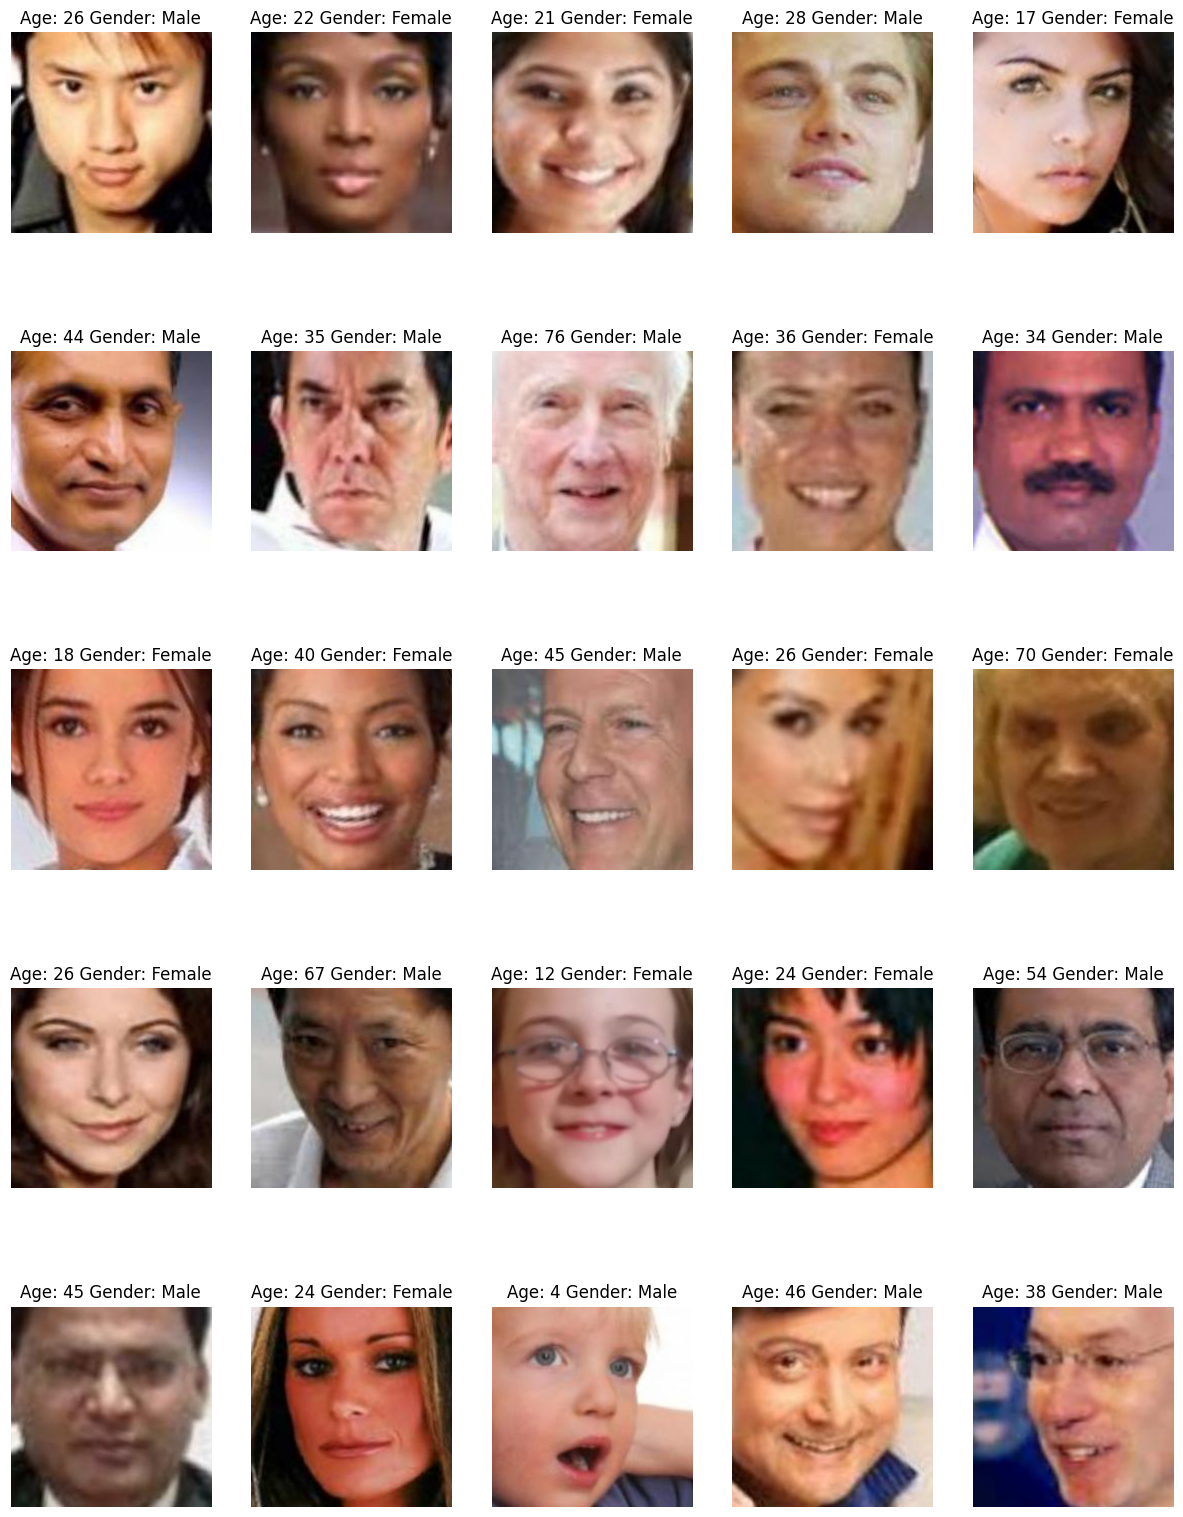

In [13]:
# Set up the plot grid
plt.figure(figsize=(15, 20))
files = df.iloc[0:25]  # Selecting the first 25 images

# Iterate through the files and display the images
for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index + 1)  # Create a subplot grid (5x5)
    
    # Read the image using OpenCV
    img = cv2.imread(file)  # Reading the image from the file path
    
    # Convert from BGR (OpenCV default) to RGB (for correct display in matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(img_rgb)
    
    # Add the title with age and gender
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    
    # Turn off the axis for better visualization
    plt.axis('off')

# Show the grid of images
plt.show()


## Extract Features

In [14]:
# Initialize list for image data
x_data = []

# Iterate through the image paths and process the images
for image_path in tqdm(image_paths):
    img = cv2.imread(image_path)  # Read the image
    img = cv2.resize(img, (48, 48))  # Resize the image to 48x48
    x_data.append(img)

# Convert the list of images to a NumPy array
x_data = np.array(x_data)

# Print out the shape of x_data
print("x_data shape: ", x_data.shape)

  0%|          | 0/23708 [00:00<?, ?it/s]

x_data shape:  (23708, 48, 48, 3)


## Normalize images

In [15]:
# normalize the images
x_data = x_data/255.0

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_data,gender_classes,test_size=0.2,
                                               shuffle=True,random_state=42)
print("Samples in Training:",x_train.shape)
print("Samples in Testing:",x_test.shape)

y_train= to_categorical(y_train,num_classes=2) #one hot encoding
y_test= to_categorical(y_test,num_classes=2)

print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

input_shape= x_train.shape[1:]
print("input shape: ",input_shape)

Samples in Training: (18966, 48, 48, 3)
Samples in Testing: (4742, 48, 48, 3)
y_train shape:  (18966, 2)
y_test shape:  (4742, 2)
input shape:  (48, 48, 3)


In [17]:
#%% vgg16
from keras.applications.vgg16 import VGG16
vgg= VGG16(include_top= False,weights="imagenet",input_shape=input_shape)
print(vgg.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
vgg_layer_list= vgg.layers

model= Sequential()

for layer in vgg_layer_list:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(2, activation="sigmoid"))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,151,970 (57.80 MB)

 Trainable params: 437,282 (1.67 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [20]:
x_val= x_train[14200:]
partial_x_train=x_train[:14200]

y_val= y_train[14200:]
partial_y_train=y_train[:14200]

In [21]:
model.compile(loss="binary_crossentropy",
              optimizer= 'adam',
              metrics=["accuracy"])

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# **Callbacks for Early Stopping, ReduceLROnPlateau, and Model Checkpoint**
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# **Model Training**
hist = model.fit(partial_x_train, partial_y_train,
                 validation_data=(x_val, y_val),
                 epochs=50,
                 batch_size=64,
                 callbacks=[early_stopping, reduce_lr, model_checkpoint])



Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6473 - loss: 0.6152 - val_accuracy: 0.7755 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7571 - loss: 0.4928 - val_accuracy: 0.7942 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7774 - loss: 0.4603 - val_accuracy: 0.7975 - val_loss: 0.4217 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7895 - loss: 0.4433 - val_accuracy: 0.8013 - val_loss: 0.4247 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7955 - loss: 0.4290 - val_accuracy: 0.8082 - val_loss: 0.4107 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7970 - loss: 0.4180 - val_accuracy: 0.8095 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8085 - loss: 0

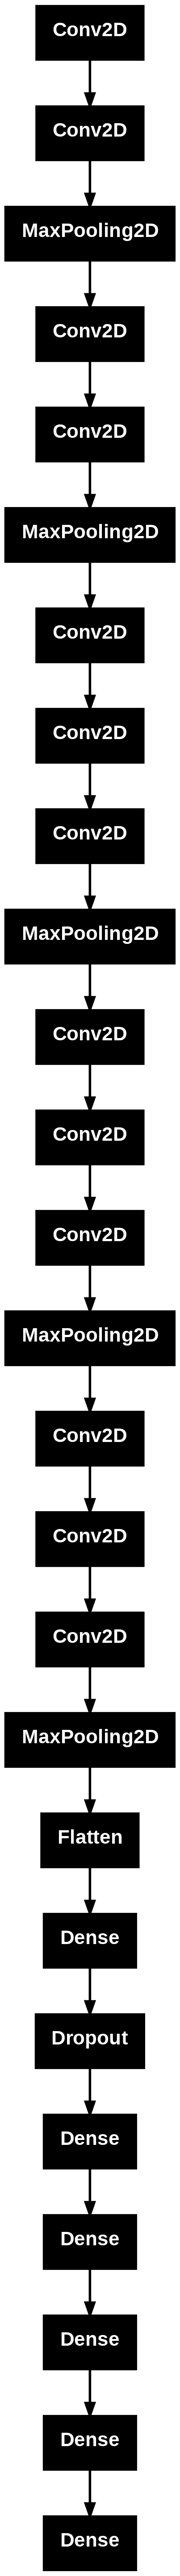

In [23]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [24]:
results= model.evaluate(x_test,y_test)
print("Results: ",results)

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7931 - loss: 0.4275
Results:  [0.4308552145957947, 0.7975537776947021]
